In [1]:
n=-7
c=-7

In [2]:
import time
start = time.time()
#importar datos y librerias
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import signal
import sklearn
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy import special
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import shift
from pmdarima.arima import auto_arima
from sklearn import linear_model
from sklearn.linear_model import Lasso

In [3]:
def Mape(y,y_pred,sample_weight):
    return np.mean(np.abs((y-y_pred)/y))*100

def isFestivo(x):
    if x:
        return 1
    else:
        return 0
    
def isFestivo1(x):
    if (np.datetime64(x) in festivos.values):
        return 1
    else:
        return 0

def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    Combinacion = pd.DataFrame(); d1 = pd.DataFrame()
    for i in data2.columns:
        d1 = data1.multiply(data2[f"{i}"] , axis="index")
        d1.columns = [f'{i}_{j}' for j in data1.columns]
        Combinacion = pd.concat([Combinacion, d1], axis = 1)
    return Combinacion

def triangular(x, a, b, c):
    return max( min( (x-a)/(b-a), (c-x)/(c-b) ), 0 )
U = np.arange(1,365)

def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    Combinacion = pd.DataFrame(); d1 = pd.DataFrame()
    for i in data2.columns:
        d1 = data1.multiply(data2[f"{i}"] , axis="index")
        d1.columns = [f'{i}_{j}' for j in data1.columns]
        Combinacion = pd.concat([Combinacion, d1], axis = 1)
    return Combinacion

In [4]:
consumofeb=pd.read_excel(r'./Consumo_feb.xlsx')
consumofeb=consumofeb[1096:]
consumofeb.index=consumofeb.fecha
consumofeb=consumofeb.drop(["fecha","prom","Lluvia","Velocidad_viento"],1)

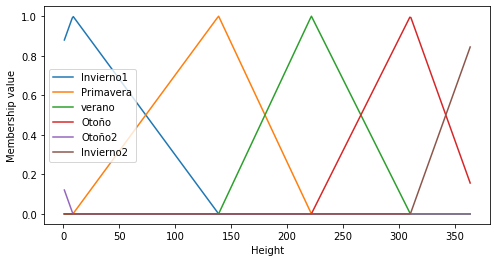

In [5]:
height = {
    'Invierno1': [310.5-365.25, 8.6529, 138.941176470588],
  'Primavera': [8.6529, 138.941176470588, 221.9375],
  'verano': [138.941176470588, 221.9375, 310.5],
  'Otoño': [221.9375, 310.5, 365.25+8.6529],
    'Otoño2': [221.9375-365.25, 310.5-365.25, 8.6529],
  'Invierno2': [310.5, 365.25+8.6529, 365.25+138.941176470588],
}


plt.figure(figsize=(8,4))
lines = []
for fuzzy_set in height.keys():
    memberships = [ triangular(x, *height[fuzzy_set]) for x in U ]
    # plot the chart
    tmp, = plt.plot(U, memberships, label=fuzzy_set)
    lines.append(tmp)
plt.legend(handles=lines)
plt.xlabel("Height")
plt.ylabel("Membership value")
plt.show()
x=[dia%max(U) for dia in range(1,len(consumofeb)+1)]


datos=pd.DataFrame()
for element in x:
    l=[]    
    for fuzzy_set in height.keys():
        p=triangular(element, *height[fuzzy_set])
        l.append(float(p))
    l=pd.DataFrame(l)
    datos=datos.append(l.T)
    
datos["fecha"]=consumofeb.index.values
t=np.arange(1,len(consumofeb)+1)
datos = datos.set_index('fecha')
datos.columns=["inv1","prim","ver","oto1","oto2","inv2"]

In [6]:
def clima(p):
    f, Pxx_den = signal.periodogram(consumofeb.iloc[:,p], 1)
    plt.plot(1/f, Pxx_den)
    plt.xlabel('periodo')
    plt.ylabel('PSD')
    #plt.axis([0, 100, 0, 10000000000])
    plt.show()
    top_50_periods = {}
    # get indices for 3 highest Pxx values
    top50_freq_indices = np.flip(np.argsort(Pxx_den), 0)[0:12]

    freqs = f[top50_freq_indices]
    power = Pxx_den[top50_freq_indices]
    periods = 1 / np.array(freqs)
    matrix=pd.DataFrame(columns=["power","periods"])
    matrix.power=power
    matrix.periods=periods
    print(matrix)

    sencos = pd.DataFrame()
    t = np.arange(1,len(consumofeb)+1)
    sencos["t"]=t
    for i  in  matrix.periods:
            sencos["{}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/(i))*t))
            sencos["{}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/(i))*t))
    sencos['ones']=1
    sencos['sen1']=np.abs(np.sin(((2*np.pi)/(365.25))*t))
    sencos['cos1']=np.abs(np.cos(((2*np.pi)/(365.25))*t))
    sencos['fecha']=consumofeb.index
    sencos.index=sencos.fecha
    sencos=sencos.drop(["fecha"],1)
    sencos=kronecker(sencos,datos)
    sencos['x']=consumofeb.iloc[:,p]

    X=sencos.iloc[:,0:-1]
    Y=sencos.iloc[:,-1]
    X_train, X_test = X[:c].values, X[c:].values
    y_train, y_test = Y[:c].values,Y[c:].values

    reg = LinearRegression().fit(X_train, y_train)
    y_predict=reg.predict(X_test)

    plt.plot(y_test,label="real")
    plt.plot(y_predict,label="predicción")
    plt.legend()
    plt.show()

    plt.plot(y_train)
    plt.plot(reg.predict(X_train))
    plt.show()
    print(Mape(y_train,reg.predict(X_train),1))
    
    nov=pd.DataFrame(np.concatenate([reg.predict(X_train),y_predict]),index=consumofeb.index,columns=["col_{}".format(p)])
    return nov


C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


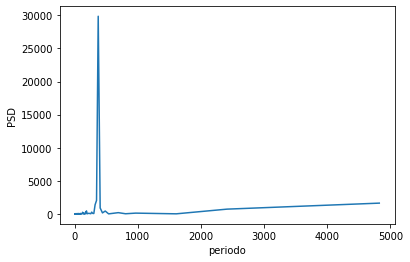

           power      periods
0   29867.495548   371.230769
1    2041.461956   344.714286
2    1629.444225  4826.000000
3    1383.410762   321.733333
4     896.988629   402.166667
5     721.860398  2413.000000
6     452.751463   185.615385
7     434.589732   482.600000
8     303.827439   178.740741
9     296.226389   172.357143
10    271.077579   268.111111
11    250.493059   123.743590


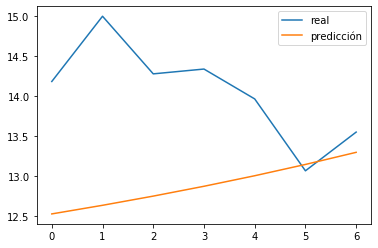

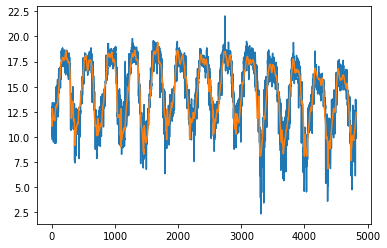

7.244394403141745


C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


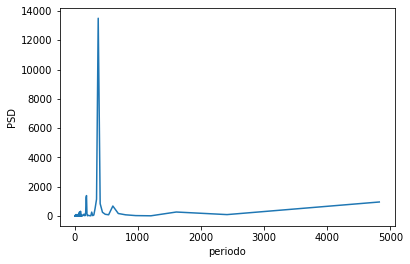

           power      periods
0   13505.413400   371.230769
1    1389.204115   185.615385
2    1246.531093   178.740741
3    1140.633767   344.714286
4     951.574467  4826.000000
5     835.832569   402.166667
6     676.326583   603.250000
7     508.925688   321.733333
8     317.069033    91.056604
9     266.646294    73.121212
10    266.190699  1608.666667
11    260.679052   268.111111


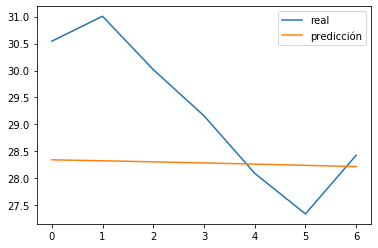

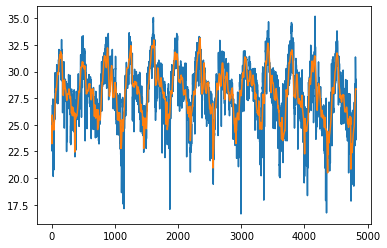

4.179020881370126


C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


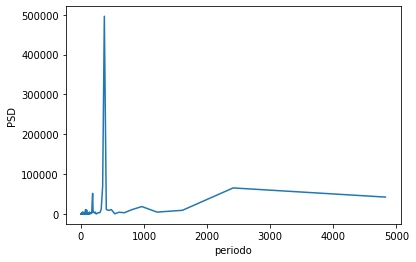

            power      periods
0   496462.432953   371.230769
1    69936.951335   344.714286
2    65249.205432  2413.000000
3    51489.337025   185.615385
4    42296.045467  4826.000000
5    31466.312453   178.740741
6    18506.542728   965.200000
7    11697.262883   321.733333
8    11147.097109   402.166667
9    10885.684967    73.121212
10   10775.261744   482.600000
11   10528.590741   804.333333


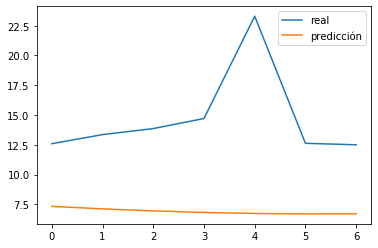

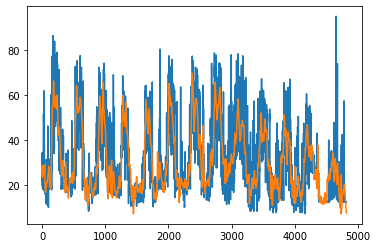

26.875351751707406


In [7]:
modelosclima=pd.DataFrame(index=consumofeb.index)
for l in range(0,3):
    nov=clima(l)
    modelosclima=modelosclima.join(nov)
modelosclima.columns=["min","max","Nubosidad"]

In [8]:
festivos=pd.read_excel(r'.\Festivos.xlsx')
festivos2=pd.read_excel(r'.\Festivos2.xlsx')
consumo=pd.read_excel(r'.\Data1.xlsx')
consumo=consumo[1096:]
consumo1=pd.read_excel(r'.\Data1.xlsx')
consumo1=consumo1[1096:]
consumo1["fecha1"]=consumo.fecha.copy()
consumo1=consumo1.set_index("fecha")

for column in festivos.columns:
    festivos[column] = pd.to_datetime(festivos[column])
for col in festivos.columns:
    consumo1[col] = consumo1.index.isin(festivos[col])
    consumo1[col]=consumo1[col].apply(isFestivo)
    clean=consumo1[col].values
    consumo1[col]=consumo1[col]+shift(clean, 1, cval=0)*.4
    consumo1[col]=consumo1[col]+shift(clean, -1, cval=0)*.4
    consumo1[col]=consumo1[col]+shift(clean, 2, cval=0)*.1
    consumo1[col]=consumo1[col]+shift(clean, -2, cval=0)*.1
    consumo1[col]=consumo1[col].apply(lambda x:x/2)
    
consumo1["ones"]=1
consumo1["t"]=np.arange(0,len(consumo1.index))+1
for col in festivos2.columns:
    consumo1[col] = consumo1.index.isin(festivos2[col])
    consumo1[col]=consumo1[col].apply(isFestivo)
consumo1 = consumo1.replace([False, True],[0, 1])
consumo1.tail()

,MWh,fecha1,Dom santo,NewYear,Constitucion,Jue santo,Vie santo,Madre,Grito,virgen,...,rev,Super bowl,Mundial,año viejo,ones,t,Benito,Trabajo,elecciones,Oscar
fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-14,198746.125920,2020-03-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,4822,0,0,0,0
2020-03-15,172471.601743,2020-03-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,4823,0,0,0,0
2020-03-16,172167.134553,2020-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,4824,1,0,0,0
2020-03-17,196979.657000,2020-03-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,4825,0,0,0,0
2020-03-18,208952.488212,2020-03-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,4826,0,0,0,0


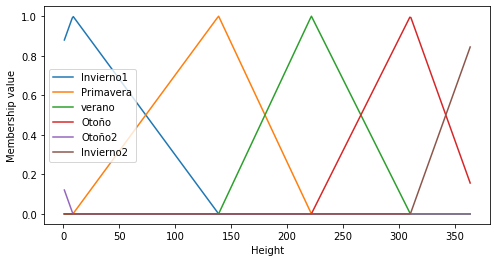

In [9]:
height = {
    'Invierno1': [310.5-365.25, 8.6529, 138.941176470588],
  'Primavera': [8.6529, 138.941176470588, 221.9375],
  'verano': [138.941176470588, 221.9375, 310.5],
  'Otoño': [221.9375, 310.5, 365.25+8.6529],
    'Otoño2': [221.9375-365.25, 310.5-365.25, 8.6529],
  'Invierno2': [310.5, 365.25+8.6529, 365.25+138.941176470588],
}


plt.figure(figsize=(8,4))
lines = []
for fuzzy_set in height.keys():
    memberships = [ triangular(x, *height[fuzzy_set]) for x in U ]
    # plot the chart
    tmp, = plt.plot(U, memberships, label=fuzzy_set)
    lines.append(tmp)
plt.legend(handles=lines)
plt.xlabel("Height")
plt.ylabel("Membership value")
plt.show()
x=[dia%max(U) for dia in range(1,len(consumo.MWh)+1)]


datos=pd.DataFrame()
for element in x:
    l=[]    
    for fuzzy_set in height.keys():
        p=triangular(element, *height[fuzzy_set])
        l.append(float(p))
    l=pd.DataFrame(l)
    datos=datos.append(l.T)
    
datos["fecha"]=consumo1.index.values
t=np.arange(1,len(consumo.MWh)+1)
datos = datos.set_index('fecha')
datos.columns=["inv1","prim","ver","oto1","oto2","inv2"]

In [10]:
consumo1=consumo1.join(datos)

In [11]:
consumo2=pd.DataFrame(index=consumo1.index)
consumo2["num"]=np.arange(0,len(consumo1.index))+1
consumo2["day"]=consumo1.fecha1.dt.weekday
consumo2["eureka1"]=consumo2.day**3
consumo2["eureka2"]=modelosclima["max"]*consumo2.num
consumo2["month"]=consumo1.fecha1.apply(lambda x:x.month)

In [12]:
consumo2

,num,day,eureka1,eureka2,month
fecha,,,,,
2007-01-01,1,0,0,24.883945,1
2007-01-02,2,1,1,47.187990,1
2007-01-03,3,2,8,69.684821,1
2007-01-04,4,3,27,94.076005,1
2007-01-05,5,4,64,120.993061,1
...,...,...,...,...,...
2020-03-14,4822,5,125,136483.942265,3
2020-03-15,4823,6,216,136412.656300,3
2020-03-16,4824,0,0,136336.405051,3


In [13]:
sem=pd.DataFrame(index=consumo1.index)
sem["fin"]=consumo1.fecha1.dt.weekday
sem["entre"]=consumo1.fecha1.dt.weekday
sem["fin"]=sem["fin"].replace([0,1,2,3,4,5,6],[.5,0,0,0,.5,1,1])
sem["entre"]=sem["entre"].replace([0,1,2,3,4,5,6],[.5,1,1,1,.5,0,0])

3.672728005238951


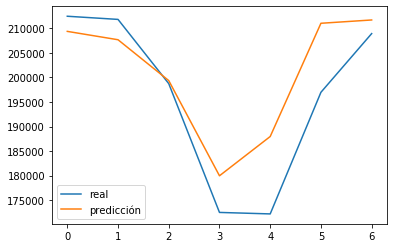

In [14]:
X=consumo2.join(modelosclima)
y=consumo1.MWh

Xmax=X.max()
my=y.mean()
sy=y.std()

X_norm=X/Xmax
y_norm=(y-my)/sy

X_norm["gplearn1"]=np.cos(X_norm.day)*X_norm.num
X_norm["gplearn2"]=X_norm.num*X_norm["min"]
X_norm["gplearn3"]=3.319**X_norm["max"]*np.cos(X_norm.day)
X_norm["gplearn8"]=3.319**X_norm["max"]*X_norm.num 
X_norm["gplearn4"]=np.cos(X_norm.day)*np.sin(X_norm.day)
X_norm["gplearn6"]=X_norm["max"]**2*X_norm["min"]**2
X_norm["gplearn7"]=1/np.cos(X_norm.day)
X_norm["gplearn10"]=X_norm["max"]*X_norm["min"]**3*np.cos(X_norm.month)**2


X_norm1=pd.get_dummies(X_norm, columns=["month","day"])
consumo1=consumo1.drop(["MWh","fecha1"],axis=1)
X_norm1=X_norm1.join(consumo1.join(sem))

X_norm1=X_norm1.drop(["month_1.0","day_1.0"],axis=1)


X_train, X_test = X_norm1[:n].values, X_norm1[n:].values
y_train, y_test = y_norm[:n].values*sy+my,y_norm[n:].values*sy+my

reg = LinearRegression().fit(X_train, y_train)
y_predict=reg.predict(X_test)

plt.plot(y_test,label="real")
plt.plot(y_predict,label="predicción")
plt.legend()
#plt.axis([0,6000,-3,3])
print(Mape(y_test,y_predict,1))

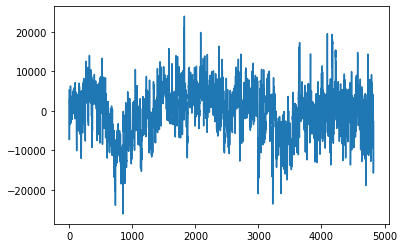

In [15]:
y_predict=reg.predict(X_norm1.values)
Tabla=pd.DataFrame(columns=['regresion','datos','resta'])
Tabla["regresion"]=y_predict
Tabla["datos"]=y_norm.values*sy+my
Tabla["resta"]=Tabla.datos-Tabla.regresion
plt.plot(Tabla.resta)
plt.show()

C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


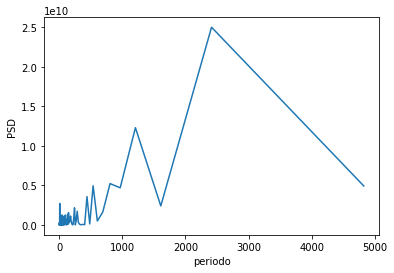

In [16]:
f, Pxx_den = signal.periodogram(Tabla.resta, 1)
plt.plot(1/f, Pxx_den)
plt.xlabel('periodo')
plt.ylabel('PSD')
#plt.axis([0, 100, 0, 10000000000])
plt.show()

In [17]:
top_50_periods = {}
# get indices for 3 highest Pxx values
top50_freq_indices = np.flip(np.argsort(Pxx_den), 0)[2:12]

freqs = f[top50_freq_indices]
power = Pxx_den[top50_freq_indices]
periods = 1 / np.array(freqs)
matrix=pd.DataFrame(columns=["power","periods"])
matrix.power=power
matrix.periods=periods
print(matrix)

sencos = pd.DataFrame()
t = np.arange(1,len(consumo.MWh)+1)
sencos["t"]=np.arange(1,len(consumo.MWh)+1)
for i  in  matrix.periods:
        sencos["{}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/(i))*t))
        sencos["{}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/(i))*t))
sencos['ones']=1
sencos['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
sencos['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
sencos['sen1']=np.abs(np.sin(((2*np.pi)/(365.25))*t))
sencos['cos1']=np.abs(np.cos(((2*np.pi)/(365.25))*t))
sencos['sen2']=np.abs(np.sin(((2*np.pi)/(28))*t))
sencos['cos2']=np.abs(np.cos(((2*np.pi)/(28))*t))
sencos["fecha"]=consumo.fecha.values
sencos=sencos.set_index("fecha")

          power      periods
0  5.226815e+09   804.333333
1  4.946571e+09   536.222222
2  4.927836e+09  4826.000000
3  4.689810e+09   965.200000
4  3.578923e+09   438.727273
5  2.716654e+09     6.994203
6  2.402896e+09  1608.666667
7  2.161793e+09   241.300000
8  1.733242e+09   283.882353
9  1.634773e+09   689.428571


In [18]:
combination=kronecker(X_norm1,sencos)

In [19]:
combination

,t_num,t_eureka1,t_eureka2,t_min,t_max,t_Nubosidad,t_gplearn1,t_gplearn2,t_gplearn3,t_gplearn8,...,cos2_elecciones,cos2_Oscar,cos2_inv1,cos2_prim,cos2_ver,cos2_oto1,cos2_oto2,cos2_inv2,cos2_fin,cos2_entre
fecha,,,,,,,,,,,,,,,,,,,,,
2007-01-01,0.000207,0.000000,0.000174,0.609577,0.750728,0.397318,0.000207,0.000126,2.461130,0.000510,...,0.0,0.0,8.572515e-01,0.000000e+00,0.0,0.0,0.117676,0.0,4.874640e-01,0.487464
2007-01-02,0.000829,0.009259,0.000658,1.203927,1.423622,0.815175,0.000817,0.000499,4.632641,0.001947,...,0.0,0.0,8.064297e-01,0.000000e+00,0.0,0.0,0.094539,0.0,0.000000e+00,0.900969
2007-01-03,0.001865,0.111111,0.001458,1.768679,2.102332,1.188779,0.001762,0.001099,6.571180,0.004323,...,0.0,0.0,7.121247e-01,0.000000e+00,0.0,0.0,0.069707,0.0,0.000000e+00,0.781831
2007-01-04,0.003315,0.500000,0.002625,2.309560,2.838193,1.494502,0.002910,0.001914,8.222953,0.007766,...,0.0,0.0,5.777342e-01,0.000000e+00,0.0,0.0,0.045756,0.0,0.000000e+00,0.623490
2007-01-05,0.005180,1.481481,0.004220,2.851601,3.650258,1.749263,0.004071,0.002954,9.433926,0.012437,...,0.0,0.0,4.088859e-01,0.000000e+00,0.0,0.0,0.024998,0.0,2.169419e-01,0.216942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-14,4818.003315,2790.509259,4590.644941,3164.605186,4117.604944,479.533558,3239.684421,3161.982223,9031.536141,13420.413575,...,0.0,0.0,8.358723e-02,1.389337e-01,0.0,0.0,0.000000,0.0,2.225209e-01,0.000000
2020-03-15,4820.001865,4823.000000,4589.198758,3195.844295,4115.454307,470.698525,2604.258122,3193.857653,7253.177723,13415.950351,...,0.0,0.0,4.885924e-14,8.392404e-14,0.0,0.0,0.000000,0.0,1.327833e-13,0.000000
2020-03-16,4822.000829,0.000000,4587.584503,3229.270678,4113.153871,464.908426,4822.000829,3227.932398,13416.552119,13410.992006,...,0.0,0.0,8.017141e-02,1.423495e-01,0.0,0.0,0.000000,0.0,1.112605e-01,0.111260


In [20]:
len(combination.columns)

1764

4.412269424109172


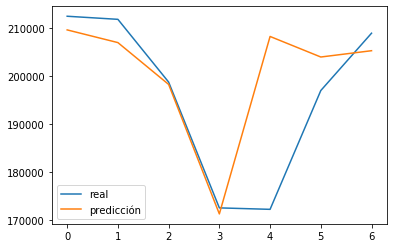

In [21]:
X_train, X_test = combination[:n].values, combination[n:].values
y_train, y_test = y_norm[:n].values*sy+my,y_norm[n:].values*sy+my

reg = LinearRegression().fit(X_train, y_train)
y_predict=reg.predict(X_test)

plt.plot(y_test,label="real")
plt.plot(y_predict,label="predicción")
plt.legend()
#plt.axis([0,6000,-3,3])
print(Mape(y_test,y_predict,1))

In [22]:
for a,b,c in zip(y_test,y_predict,y_norm[n:].index):
    print(Mape(a,b,1),c)

1.3423283947715736 2020-03-12 00:00:00
2.2930965251481186 2020-03-13 00:00:00
0.24536409313290572 2020-03-14 00:00:00
0.7306327541856014 2020-03-15 00:00:00
20.97071543285113 2020-03-16 00:00:00
3.5536324200273404 2020-03-17 00:00:00
1.7501163486475328 2020-03-18 00:00:00


In [23]:
residuales=(y_train)-(reg.predict(X_train))
residuos=pd.DataFrame()
residuos["residuales"]=residuales
residuos["fecha"]=y_norm[:n].index.copy()
residuos=residuos.set_index("fecha")
result = seasonal_decompose(residuos, model='additive')

0.9303026851918919

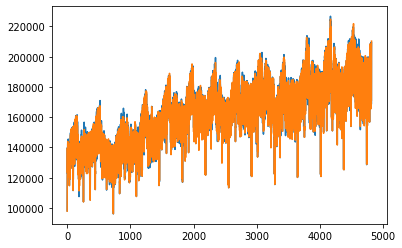

In [24]:
plt.plot(y_train)
plt.plot(reg.predict(X_train))
Mape(y_train,reg.predict(X_train),1)

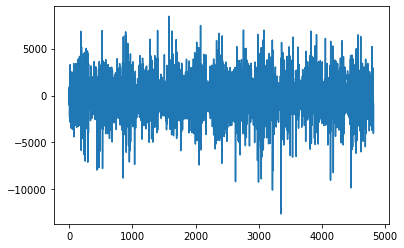

In [25]:
plt.plot(residuales)

In [26]:
consumo1.columns

Index(['Dom santo', 'NewYear', 'Constitucion', 'Jue santo', 'Vie santo',
       'Madre', 'Grito', 'virgen', 'muertos', 'Virgen2', 'Navidad',
       'nochebuena', 'toma', 'sab santo', 'rev', 'Super bowl', 'Mundial',
       'año viejo', 'ones', 't', 'Benito', 'Trabajo', 'elecciones', 'Oscar',
       'inv1', 'prim', 'ver', 'oto1', 'oto2', 'inv2'],
      dtype='object')

In [27]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(residuales,exog=consumo1[0:n],start_p=1, start_q=1, max_p=7, max_q=7, max_d=7,
                     trace=True, error_action='ignore', suppress_warnings=True, stepwise=True,m=1,
                    seasonal=False,Stationary=True, n_jobs = -1)

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:303: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=86030.056, BIC=86055.977, Time=0.737 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=87365.753, BIC=87378.713, Time=0.135 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=86037.999, BIC=86057.440, Time=0.280 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=86243.026, BIC=86262.467, Time=0.532 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=87363.753, BIC=87370.233, Time=0.069 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=85442.400, BIC=85474.802, Time=6.283 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=86026.403, BIC=86052.324, Time=0.385 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=85402.053, BIC=85440.934, Time=8.238 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=85980.987, BIC=86013.389, Time=0.617 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=8

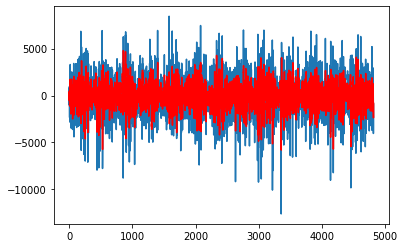

In [28]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(residuales, order=(7,0,2))
results = mod.fit()
plt.plot(residuales)
plt.plot(results.fittedvalues, color='red')

In [29]:
extra=results.predict(len(y_train),len(y_train)-n)
extra=extra[1:]

4.396652417578314


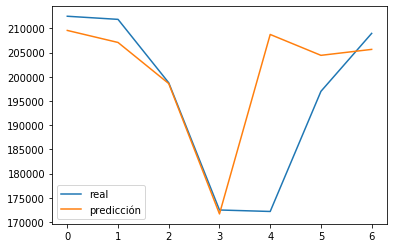

In [30]:
plt.plot(y_test,label="real")
plt.plot(y_predict+extra,label="predicción")
plt.legend()
#plt.axis([0,6000,-3,3])
print(Mape(y_test,y_predict+extra,1))

In [31]:
pd.DataFrame(y_predict+extra)

,0
0,209563.345184
1,207077.661313
2,198583.560192
3,171661.240481
4,208729.001951
5,204417.818156
6,205647.368829


In [32]:
for a,b,c in zip(y_test,y_predict+extra,y_norm[n:].index):
    print(Mape(a,b,1),c)

1.3789135009825972 2020-03-12 00:00:00
2.251878977075395 2020-03-13 00:00:00
0.08179567121212195 2020-03-14 00:00:00
0.4698519953540277 2020-03-15 00:00:00
21.236264106684757 2020-03-16 00:00:00
3.776106258712962 2020-03-17 00:00:00
1.5817564130263382 2020-03-18 00:00:00


In [33]:
lasso_reg = Lasso(normalize=True,max_iter=1000)
#Fitting the Training data to the Lasso regressor
lasso_reg.fit(X_train,y_train)
coeff = lasso_reg.coef_
#coeff
#Predicting for X_test
y_pred_lass =lasso_reg.predict(X_test)

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259125753.42366028, tolerance: 217255099.84265798
  positive)


In [34]:
print(np.sum(abs(lasso_reg.coef_)==0))
len(lasso_reg.coef_)

1519


1764

2.3943056321782197


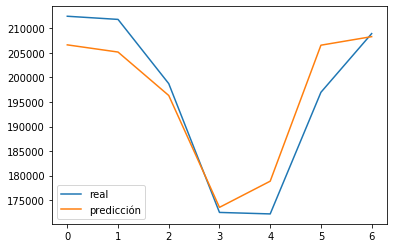

In [35]:
plt.plot(y_test,label="real")
plt.plot(y_pred_lass+extra,label="predicción")
plt.legend()
#plt.axis([0,6000,-3,3])
print(Mape(y_test,y_pred_lass+extra,1))

In [36]:
pd.DataFrame(y_pred_lass+extra)

,0
0,206654.890601
1,205189.869821
2,196328.057045
3,173504.383392
4,178846.739713
5,206588.324143
6,208333.322851


In [37]:
for a,b,c in zip(y_test,y_pred_lass+extra,y_norm[n:].index):
    print(Mape(a,b,1),c)

2.74764022540666 2020-03-12 00:00:00
3.1429846137221142 2020-03-13 00:00:00
1.2166621432345814 2020-03-14 00:00:00
0.5988125805206584 2020-03-15 00:00:00
3.8797213982554744 2020-03-16 00:00:00
4.877999733310428 2020-03-17 00:00:00
0.2963187307976235 2020-03-18 00:00:00
